In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm

### Задание №1
Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

### Задание №2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

### Задание №3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?
_______________________________________________________________________________________________________________________________

## Задание №1
Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

Считаем данные.

In [2]:
reg_data = pd.read_csv("shared/problem1-reg_data.csv", sep=';')
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [3]:
auth_data = pd.read_csv("shared/problem1-auth_data.csv", sep=';')
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [4]:
def retention(reg_data, auth_data):
    #Преобразуем timestamp в дату до дней для двух таблиц.
    reg_data.reg_ts = pd.to_datetime(reg_data.reg_ts, unit='s', origin='1970-01-01')
    reg_data['reg_ts'] = reg_data.reg_ts.dt.strftime('%Y-%m-%d')
    reg_data['reg_ts'] = pd.to_datetime(reg_data.reg_ts)
    auth_data.auth_ts = pd.to_datetime(auth_data.auth_ts, unit='s', origin='1970-01-01')
    auth_data['auth_ts'] = auth_data.auth_ts.dt.strftime('%Y-%m-%d')
    auth_data['auth_ts'] = pd.to_datetime(auth_data.auth_ts)
    
    #Соединим две таблицы в одну по uid
    data = reg_data.merge(auth_data, on='uid')
    
    #Сделаем новый столбик для разницы даты использования игры и даты регистрации. Этот столбик показывает нам насколько "стар"
    #пользователь в день очередного захода в приложение
    #прибавим один день для корректности количества дней использования приложения и переведём количество дней в число
    data['diff'] = (data.auth_ts - data.reg_ts + timedelta(days=1)).dt.days
    
    #Сгруппируем по дате регистрации и разнице дней, в качестве аггрегирующей функции возьмём количество уникальных пользователей
    ret_cohort = data.groupby(['reg_ts', 'diff']).agg({'uid':'nunique'}).sort_values(by='diff').reset_index()
    
    #Сделаем новую pivot таблицу для удобства
    ret_cohort = ret_cohort.pivot(index='reg_ts', columns='diff', values='uid')
    
    #Наконец посчитаем retention
    retention = ret_cohort.divide(ret_cohort[1], axis=0).round(3)
    retention = retention.fillna(0)
    
    #Нарисуем heatmap. Для наглядности будем использовать данные с последних 10 дат использования и 10 дней.
    retention_for_plot = retention[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]].tail(10)
    plt.figure(figsize=(18, 14))
    plt.title('Retention')
    ax = sns.heatmap(data=retention_for_plot, annot=True, fmt='.0%', cmap='rocket_r')
    ax.set_yticklabels(retention_for_plot.index)
    fig=ax.get_figure()

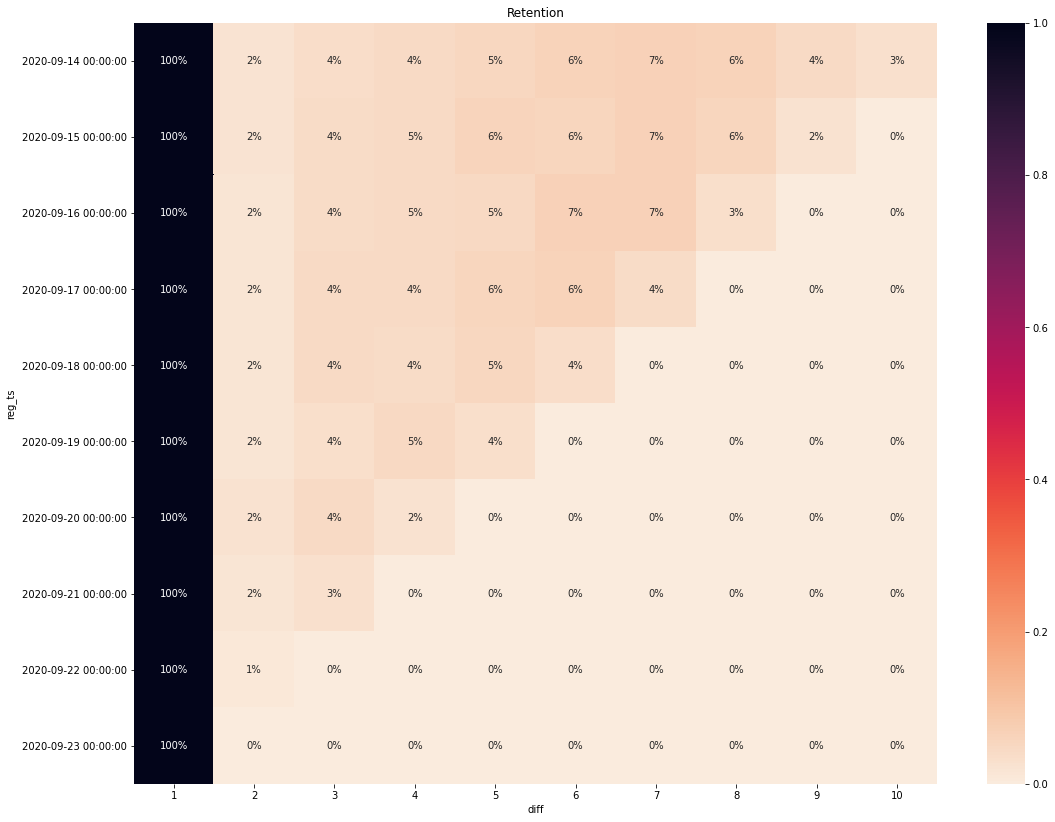

In [5]:
retention(reg_data, auth_data)

## Задание №2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [6]:
df = pd.read_csv("https://stepik.org/media/attachments/lesson/409318/problem2.csv", sep=';')
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Посмотрим на структуру данных.

In [7]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [8]:
df.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


Мы можем видеть, что большая часть значений revenue равна нулю.

In [9]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [10]:
df.testgroup.value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

Посмотрим на распределение значений выручки для двух тестовых групп.

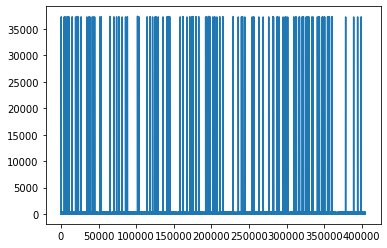

In [11]:
df.query('testgroup == "a"').revenue.plot()

In [12]:
df.query('testgroup == "a"').revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

Видим, что в контрольной группе присутствуют большие выбросы. У 123 пользователей revenue выше 30000. У остальных же revenue максимум равно 400.

In [13]:
df.query('testgroup == "a" and revenue > 30000')

,user_id,revenue,testgroup
416,417,37324,a
4428,4429,37304,a
5777,5778,37315,a
8065,8066,37307,a
8743,8744,37334,a
...,...,...,...
360696,360697,37347,a
378668,378669,37297,a
389341,389342,37298,a
394580,394581,37302,a


In [14]:
df.query('testgroup == "a" and revenue < 30000').describe()

,user_id,revenue
count,201980.000000,201980.000000
mean,202555.326958,2.702926
std,116802.650558,28.985815
min,2.000000,0.000000
25%,101494.750000,0.000000
50%,202985.500000,0.000000
75%,303550.500000,0.000000
max,404769.000000,400.000000


В тестовой группе выбросов нет.

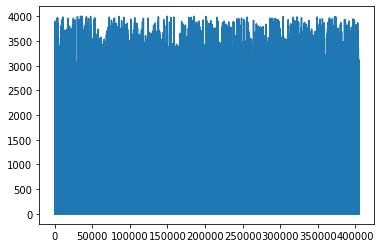

In [15]:
df.query('testgroup == "b"').revenue.plot()

In [16]:
df.query('testgroup == "b"').revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

Видим, что распределение скошенно и не является нормальным. На всякий случай проверим это тестом Шапиро.

In [18]:
p_control = stats.shapiro(df.query('testgroup == "a"').revenue.sample(1000))[1]

alpha = 0.05
if p_control > alpha:
    print('Распределение является нормальным')
else:
    print('Распределение не является нормальным')

Распределение не является нормальным


In [19]:
p_test = stats.shapiro(df.query('testgroup == "b"').revenue.sample(1000))[1]

alpha = 0.05
if p_test > alpha:
    print('Распределение является нормальным')
else:
    print('Распределение не является нормальным')

Распределение не является нормальным


С помощью критерия Манна-Уитни и бутсрепа проверим статистическую значимость разницы средних.

In [20]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

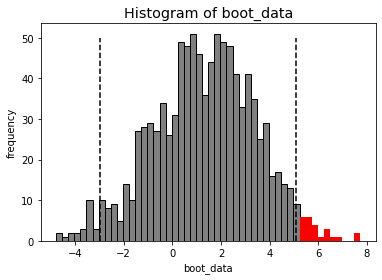

In [21]:
bootstrap_mean_data = get_bootstrap(df.query('testgroup == "b"').revenue, df.query('testgroup == "a"').revenue, statistic = np.mean)

In [22]:
bootstrap_mean_data["p_value"]

0.5207042465757498

Можем видеть, что полученное p-value больше 0,05. Это значит, что мы оставляем нулевую гипотезу о том, что **нет** статистической разницы между ARPU для тестовой и контрольной группы.

Вспомним, что в контрольной группе у нас было много выбросов. Снова проведём бутстреп анализ, но уже исключив этих 123 пользователей.

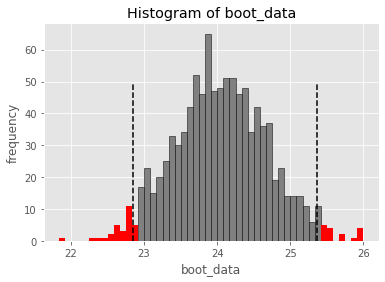

In [23]:
bootstrap_mean_data2 = get_bootstrap(df.query('testgroup == "b"').revenue, df.query('testgroup == "a" and revenue < 30000').revenue, statistic = np.mean)

In [24]:
bootstrap_mean_data2["p_value"]

0.0

Сейчас видим, что p-value меньше 0,05. Это значит, что необходимо понять природу этих выбросов. Для этого необходимо посмотреть более подробно на этих 123 пользователей.

Также проверим метрику конверсии в платящего пользователя.

In [25]:
conv_control = df.query('testgroup == "a" and revenue > 0').user_id.nunique() / df.query('testgroup == "a"').user_id.nunique()
conv_control

0.009539690157988749

In [26]:
conv_test = df.query('testgroup == "b" and revenue > 0').user_id.nunique() / df.query('testgroup == "b"').user_id.nunique()
conv_test

0.008906235351586593

Посмотрим на конверсию в контрольной группе без выбросов. Можем видеть, что она немного больше, чем в тестовой.

In [27]:
conv_control2 = df.query('testgroup == "a" and revenue > 0 and revenue < 30000').user_id.nunique() / df.query('testgroup == "a"').user_id.nunique()
conv_control2

0.008931089592930338

### Выводы
С помощью критерия Манна-Уитни не удалось выявить статистически значимых различий между группами. Но в группе **a** присутствуют большие выбросы. Поэтому необходимо проверить откуда они взялись: это сбой системы или же в этой группе есть очень лояльные пользователи.
Если смотреть на конверсию, то в группе **a** она выше, чем в группе **b**. Но ARPU в группе **b** повысился на 5%. Поэтому также следует посмотреть, что послужило причиной этому.
По результам мы принимаем изменения для всех пользователей, но перед этим проверив пользователей группы **a** с выбросами. Если это реальные люди, то следует отдельно провести A/B тест на них.

## Задание №3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

#### Для первого события:
* DAU. Как изменяется дневная аудитория во время события по сравнению с другими днями.
+ Конверсия в событие. Как много пользователей приняли участие в событии.
Average play time. Сколько времени в среднем пользователи играли в событие.
Average play time to the end of event. Насколько быстро пользователи проходили это событие полностью по сравнению с другими событиями (насколько сложное оказалось событие).
Number of winners / number of participants. Соотношение пользователей прошедних событие по отношению к числу пользователей начавших проходить событие.
Длительность сессии пользователя во время ивента.
ARPU, ARPPU за событие.

2. Для усложнённой механики второго события:
Можно использовать те же метрики, что и для первого события. Также нужно добавить
Churn rate. Сравнить как много пользователей бросали играть в это событие.
Количество раз, которое пользователь откатывается назад
Среднюю глубину прохождения. На какой максимальный уровень доходили участники прежде чем перестать играть в событие.
Уровень, на котором большинство участников переставали играть.